the question remains: how reasonable is it to observe your data if a model is true? This question is addressed by hypothesis tests. They are the icing on the inference cake. After completing this chapter, you will be able to carefully construct and test hypotheses using hacker statistics.



### Generating a permutation sample
In the video, you learned that permutation sampling is a great way to simulate the hypothesis that two variables have identical probability distributions. This is often a hypothesis you want to test, so in this exercise, you will write a function to generate a permutation sample from two data sets.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    

    # Concatenate the data sets: data
    
    data = np.concatenate([data1,data2])

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [32]:
def ecdf(data_list,color,alpha):
    for dt in data_list:
        x=np.sort(dt)
        y=np.arange(1,len(x)+1)/len(x)
        plt.plot(x,y,marker='.',linestyle='none',color=color,alpha=alpha)

### Visualizing permutation sampling
To help see how permutation sampling works, in this exercise you will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in June (a dry month) and November (a wet month). We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

In [33]:
rain_june=np.random.normal(10,2,size=100)
rain_november=np.random.exponential(10,size=100)

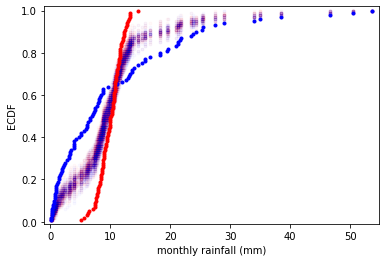

In [35]:
x_1=[]
x_2=[]
for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june,rain_november)


    # Compute ECDFs
    x_1.append(perm_sample_1)
    x_2.append(perm_sample_2)


# Create and plot ECDFs from original data
ecdf(x_1,'red',0.02)
ecdf(x_2,'blue',0.02)
ecdf([rain_november],'blue',1)
ecdf([rain_june],'red',1)
# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()

### Generating permutation replicates
As discussed in the video, a permutation replicate is a single value of a statistic computed from a permutation sample. As the draw_bs_reps() function you wrote in chapter 2 is useful for you to generate bootstrap replicates, it is useful to have a similar function, draw_perm_reps(), to generate permutation replicates. You will write this useful function in this exercise

In [37]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(rain_june,rain_november)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(rain_june,rain_november,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.6908


The p-value tells you that there is about a 69% chance that you would get the difference of means observed in the experiment if rains in june and november were exactly the same. A p-value below 0.01 is typically said to be "statistically significant," but: warning! warning! warning! You have computed a p-value; it is a number. I encourage you not to distill it to a yes-or-no phrase. p = 0.006 and p = 0.000000006 are both said to be "statistically significant," but they are definitely not the same!

### Bootstrap hypothesis tests

### A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

In [44]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates
# Make an array of translated impact forces: translated_force_b
translated_force_b = rain_june+10.5-np.mean(rain_june)

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b,np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(rain_june)) / 10000

# Print the p-value
print('p = ',p)

p =  0.0074


### A two-sample bootstrap hypothesis test for difference of means
We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [47]:
force_a=rain_june
force_b=rain_november
forces=np.concatenate([rain_june,rain_november])
# Compute mean of all forces: mean_force
mean_force = np.mean(forces)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b- np.mean(force_b)+mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted,np.mean,10000)
bs_replicates_b = draw_bs_reps(force_b_shifted,np.mean,10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_b-bs_replicates_a
# Compute and print p-value: p
p = np.sum(bs_replicates<=np.mean(force_b)-np.mean(force_a)) / len(bs_replicates)
print('p-value =', p)


p-value = 0.7054


### A/B Test
The vote for the Civil Rights Act in 1964
The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

In [51]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True]*136+[False]*35)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(dems) / len(dems)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dems,reps,frac_yea_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0001


In [54]:
nht_dead=np.random.exponential(10,size=1000)
nht_live=np.random.exponential(9.6,size=1000)
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = np.mean(nht_dead)-np.mean(nht_live)

# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(nht_live,nht_dead,diff_of_means,10000)


# Compute and print the p-value: p
p = np.sum(perm_replicates<=nht_diff_obs)/len(perm_replicates)
print('p-val =', p)

p-val = 0.8102
